# Breast cancer classifier

Import libraries

In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    train_test_split, cross_val_score, cross_validate,
    StratifiedKFold, GridSearchCV, RandomizedSearchCV
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, precision_recall_curve, ConfusionMatrixDisplay
)
from sklearn.datasets import load_breast_cancer
from xgboost import XGBClassifier

Load dataset

In [126]:
data = load_breast_cancer()

In [127]:
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)


In [128]:
print("Shape:", X.shape)
X.head()
X.head(5)

Shape: (569, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [129]:
print("Clases:", data.target_names)
y.value_counts()

Clases: ['malignant' 'benign']


1    357
0    212
Name: count, dtype: int64

Target encoding

In [130]:
print(data.target_names)
print(set(data.target))

# the mapping follows the index:
# malignant > 0
# bening > 1

['malignant' 'benign']
{np.int64(0), np.int64(1)}


## EDA

Basic statistics

In [131]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
mean radius,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
mean texture,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
mean perimeter,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
mean area,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
mean smoothness,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
mean compactness,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
mean concavity,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
mean concave points,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
mean symmetry,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400
mean fractal dimension,569.0,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744


### 1. Data Quality Checks


Check for missing values

In [132]:
X.isnull().sum().sum()

# No missing values in this dataset

np.int64(0)

Check data types

In [133]:
print('Data types:')
print(X.dtypes)

Data types:
mean radius                float64
mean texture               float64
mean perimeter             float64
mean area                  float64
mean smoothness            float64
mean compactness           float64
mean concavity             float64
mean concave points        float64
mean symmetry              float64
mean fractal dimension     float64
radius error               float64
texture error              float64
perimeter error            float64
area error                 float64
smoothness error           float64
compactness error          float64
concavity error            float64
concave points error       float64
symmetry error             float64
fractal dimension error    float64
worst radius               float64
worst texture              float64
worst perimeter            float64
worst area                 float64
worst smoothness           float64
worst compactness          float64
worst concavity            float64
worst concave points       float64
worst sy

Check for duplicates

In [134]:
print(f"\nDuplicate rows: {X.duplicated().sum()}")
#  No duplicate rows


Duplicate rows: 0


### 2. Target Variable Analysis


Class distribution:
 1    357
0    212
Name: count, dtype: int64
Class percentages:
 1    62.742
0    37.258
Name: proportion, dtype: float64


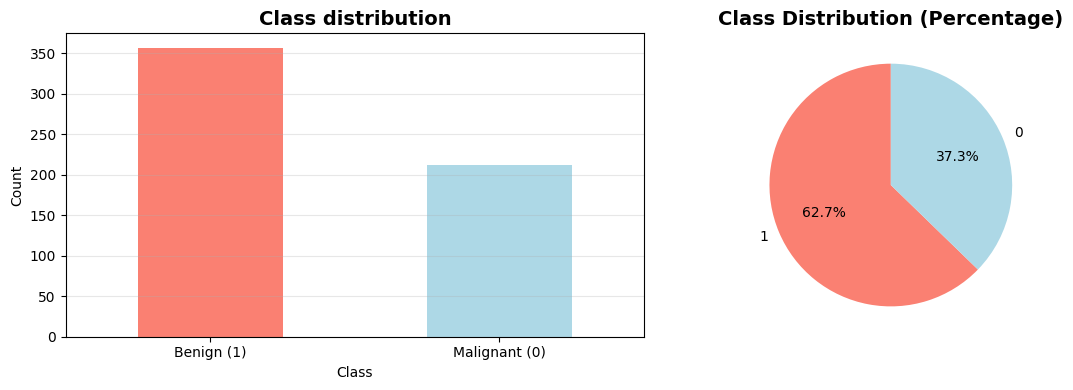

In [135]:
print("Class distribution:\n",y.value_counts())
print("Class percentages:\n", round(y.value_counts(normalize=True)*100, 3))

# count plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
y.value_counts().plot(kind='bar', ax=axes[0], color=['salmon', 'lightblue'])
axes[0].set_title('Class distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Benign (1)', 'Malignant (0)'], rotation=0)
axes[0].grid(axis='y', alpha=0.3)

# pie chart
y.value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', 
                       colors=['salmon', 'lightblue'], startangle=90)
axes[1].set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

In [136]:
print("Class imbalance ratio: ", round(y.value_counts()[1]/y.value_counts()[0],3))

# Check for class imbalance
print(f"\nClass imbalance ratio: {y.value_counts()[0] / y.value_counts()[1]:.2f}")
if abs(y.value_counts()[0] / y.value_counts()[1] - 1) > 0.3:
    print("⚠️ Warning: Significant class imbalance detected!")
else:
    print("✓ Classes are relatively balanced")

Class imbalance ratio:  1.684

Class imbalance ratio: 0.59
⚠️ Warning: Significant class imbalance detected!


### 3. Feature Distributions


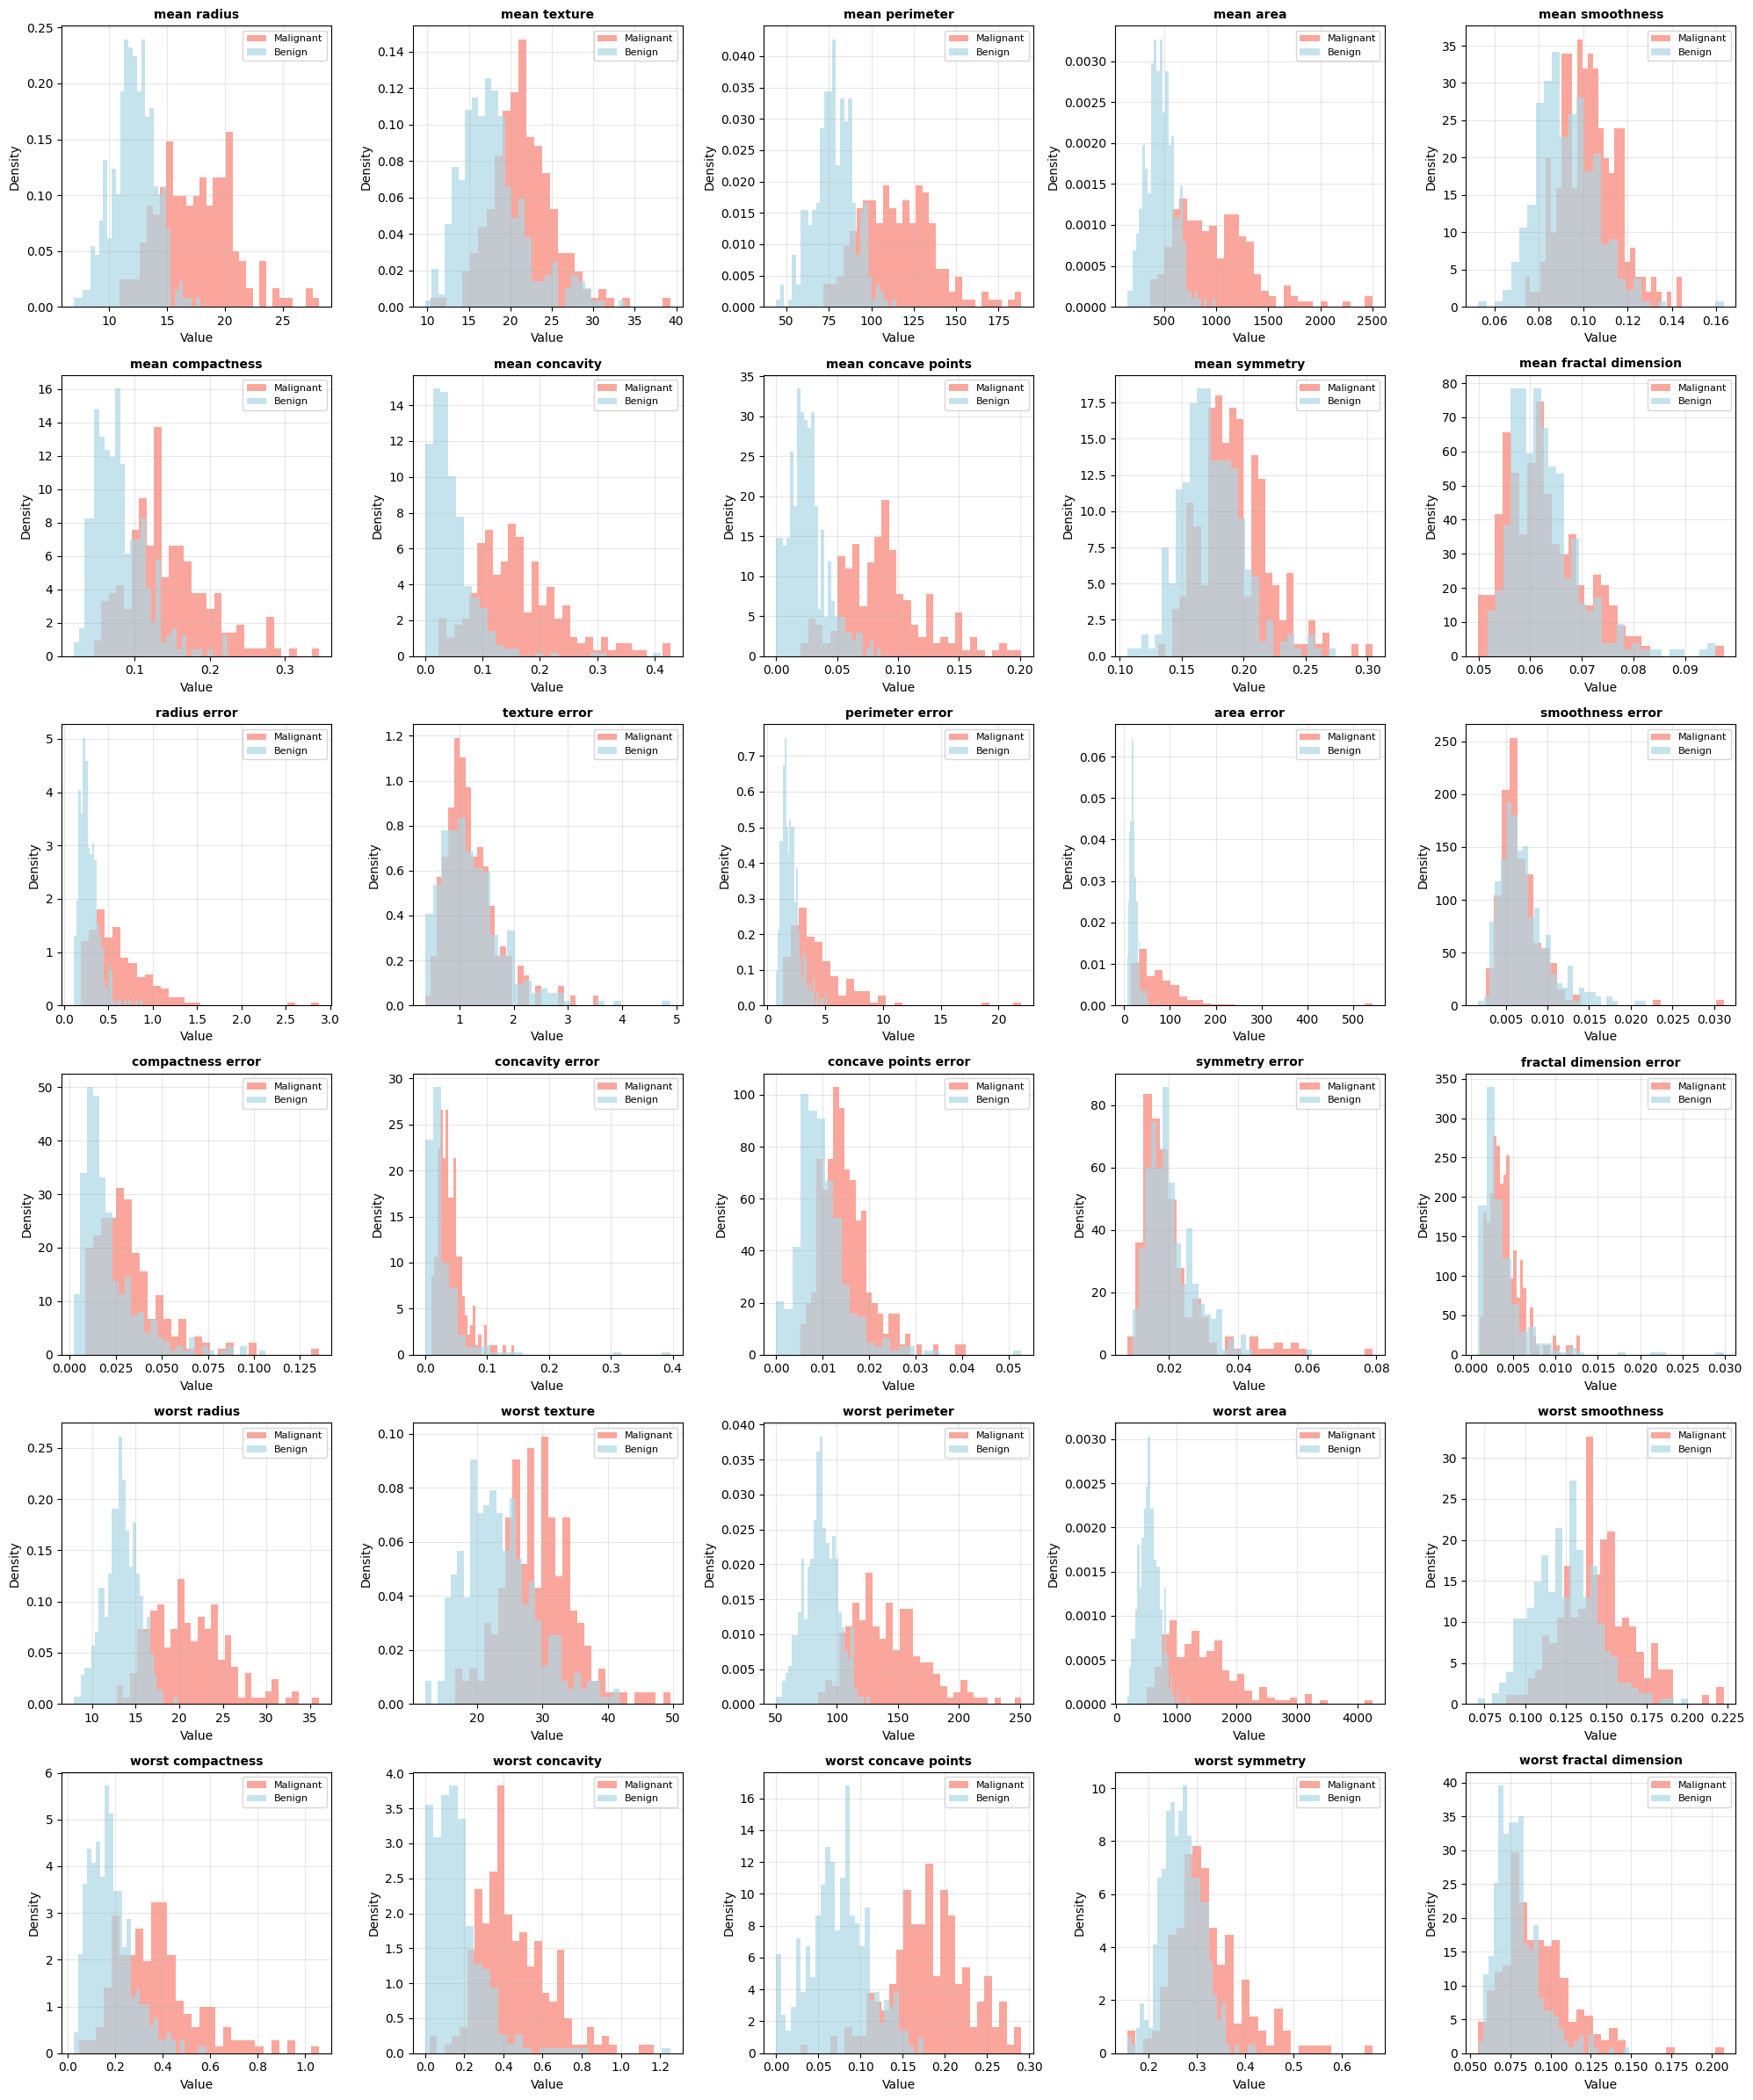

In [137]:
# Distribution of features by class
fig, axes = plt.subplots(6, 5, figsize=(20, 24))
axes = axes.ravel()

for idx, col in enumerate(X.columns):
    axes[idx].hist(X[y == 0][col], bins=30, alpha=0.7, label='Malignant', color='salmon', density=True)
    axes[idx].hist(X[y == 1][col], bins=30, alpha=0.7, label='Benign', color='lightblue', density=True)
    axes[idx].set_title(col, fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Density')
    axes[idx].legend(fontsize=8)
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()


### 4. Box Plots for Outlier Detection


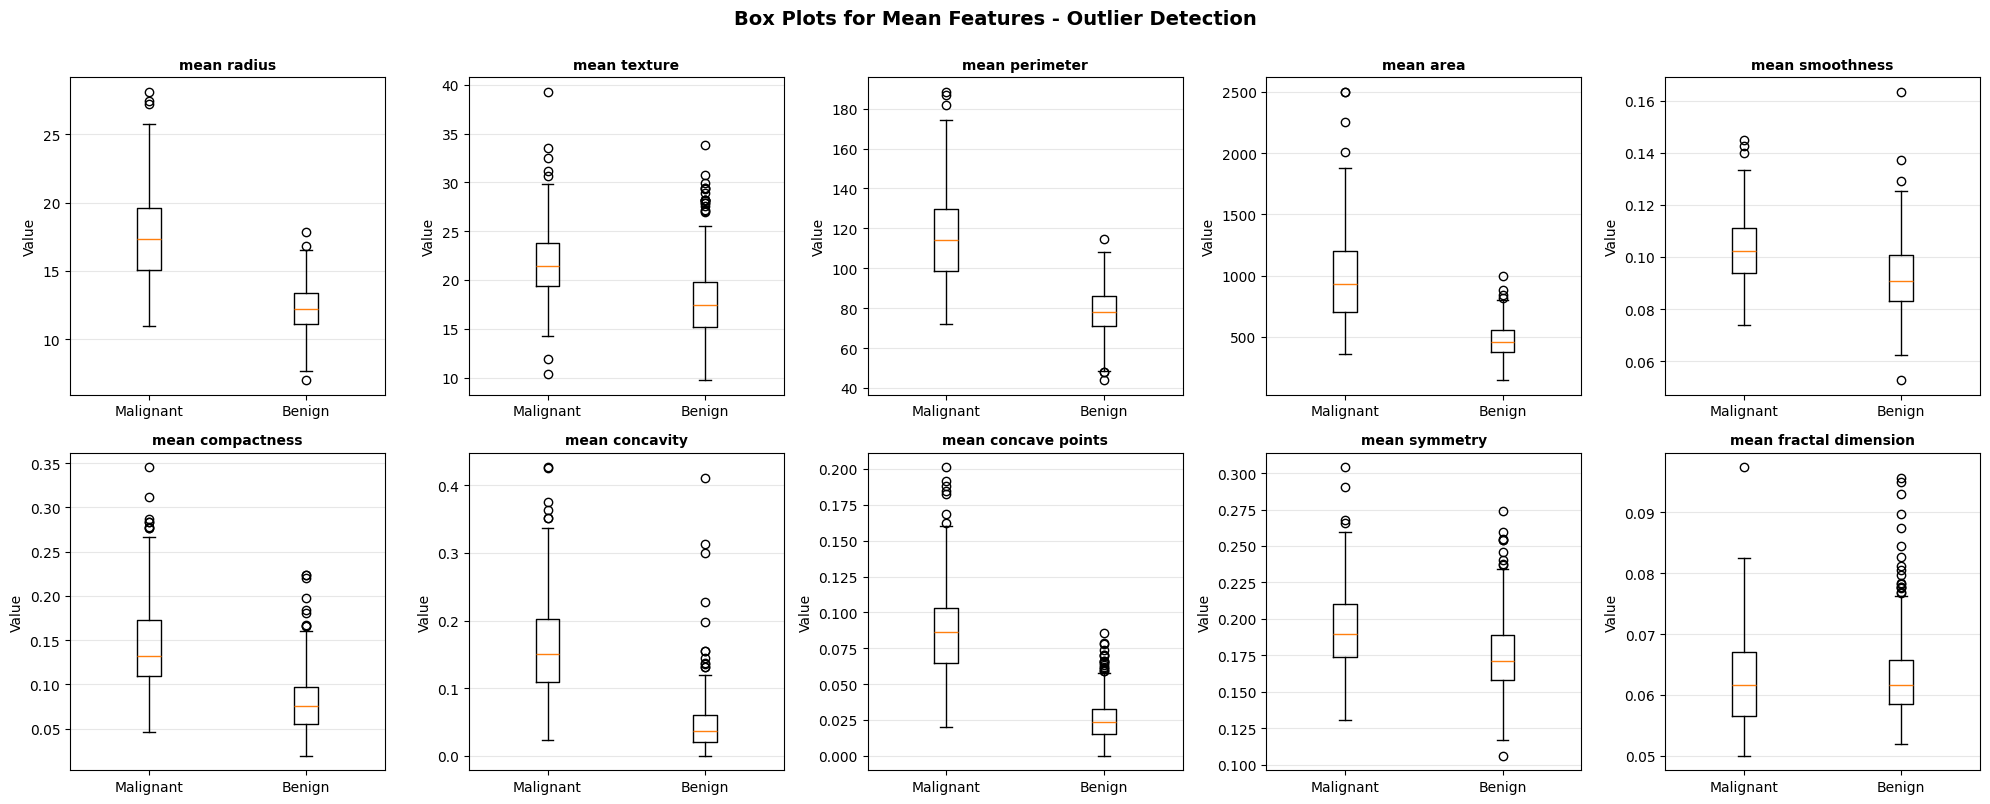

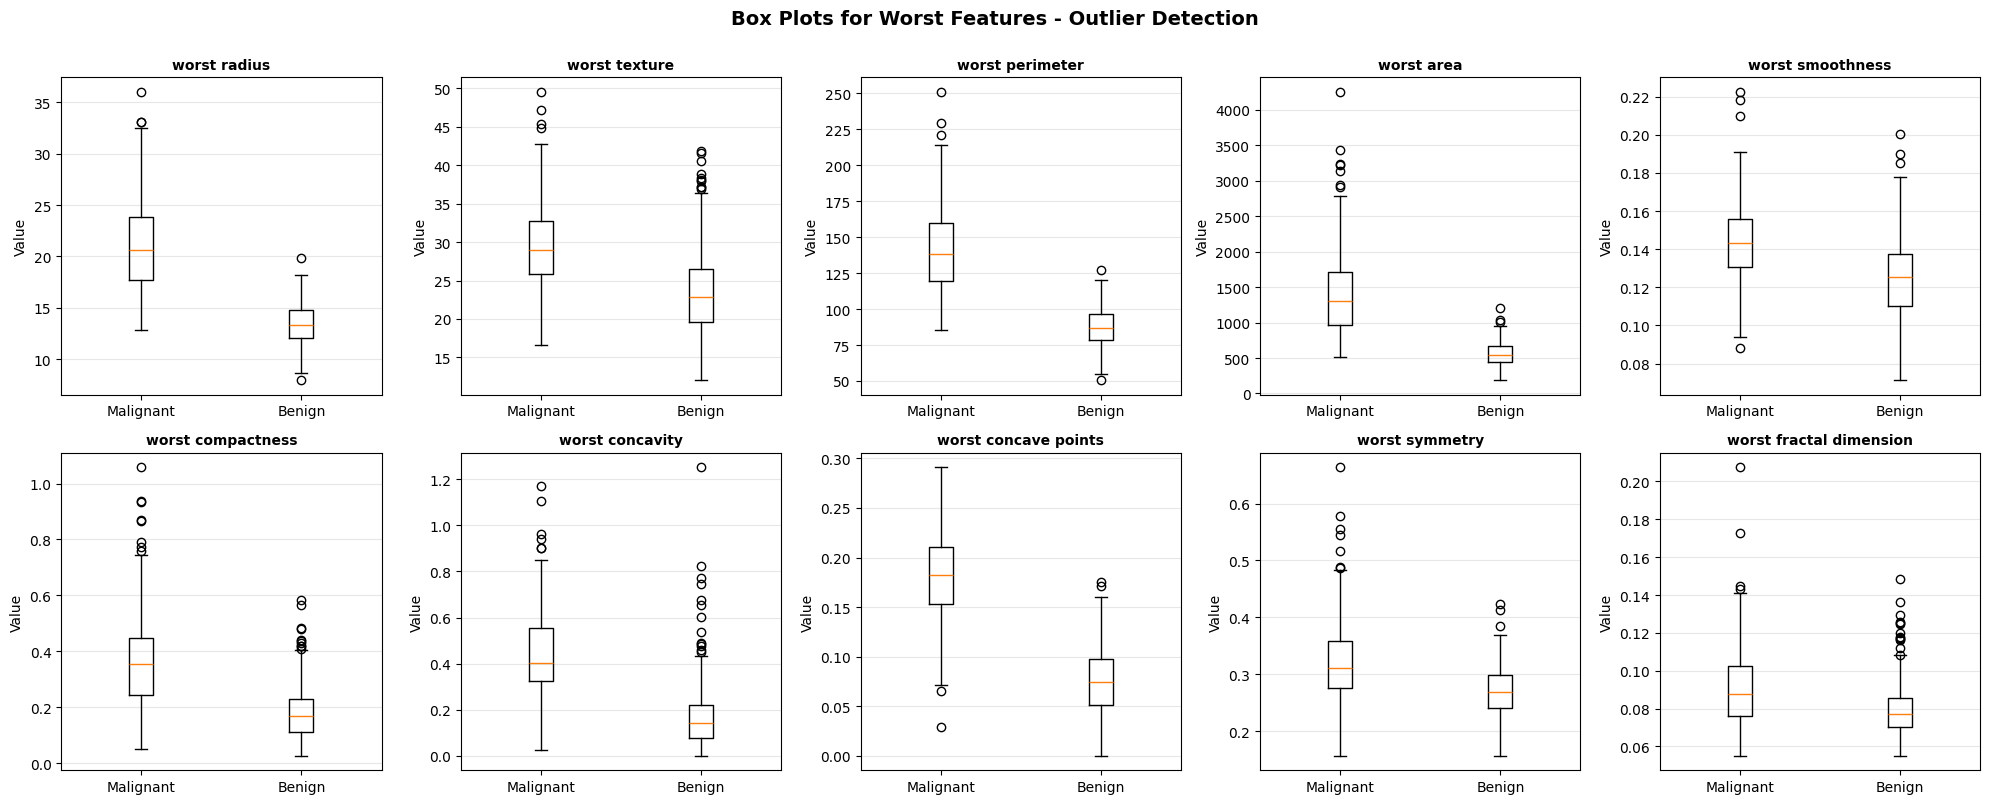

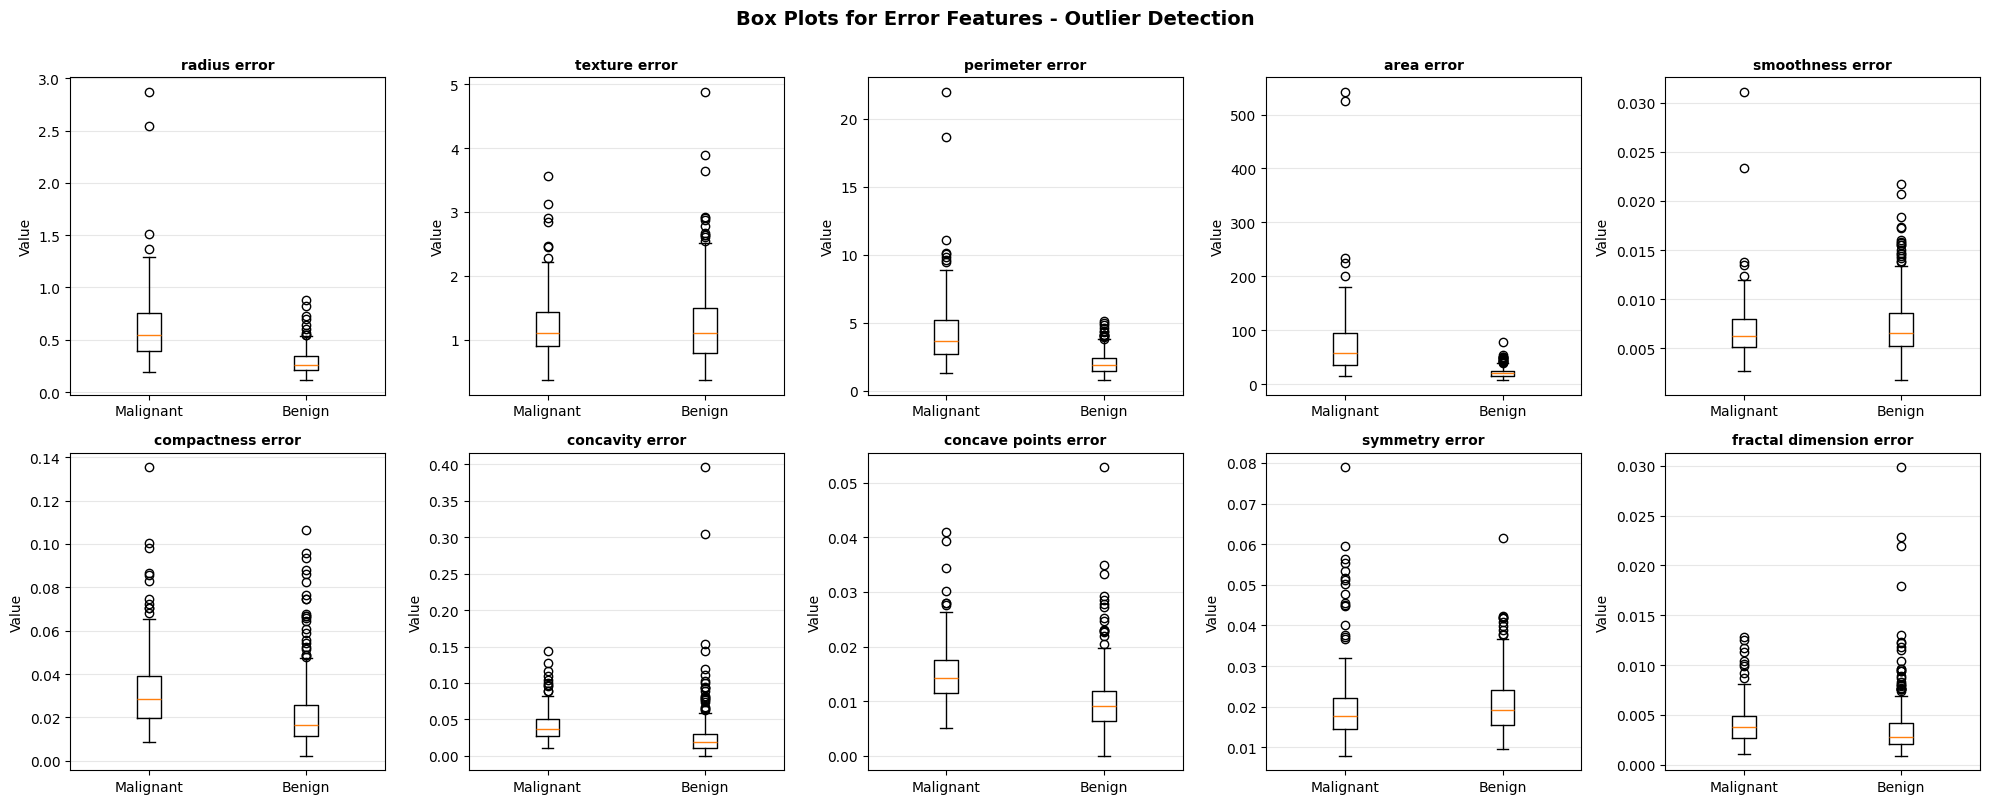

In [138]:
# Box plots for all feature types (mean, worst, and error)
mean_features = [col for col in X.columns if 'mean' in col]
worst_features = [col for col in X.columns if 'worst' in col]
error_features = [col for col in X.columns if 'error' in col]

# Create separate plots for each feature type
feature_types = [
    ('Mean Features', mean_features),
    ('Worst Features', worst_features),
    ('Error Features', error_features)
]

for feature_type_name, features in feature_types:
    n_features = len(features)
    n_cols = 5
    n_rows = (n_features + n_cols - 1) // n_cols  # Ceiling division
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
    axes = axes.ravel() if n_rows > 1 else [axes] if n_features == 1 else axes
    
    for idx, col in enumerate(features):
        data_to_plot = [X[y == 0][col], X[y == 1][col]]
        axes[idx].boxplot(data_to_plot, tick_labels=['Malignant', 'Benign'])
        axes[idx].set_title(col, fontsize=10, fontweight='bold')
        axes[idx].set_ylabel('Value')
        axes[idx].grid(axis='y', alpha=0.3)
    
    # Hide unused subplots
    for idx in range(n_features, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(f'Box Plots for {feature_type_name} - Outlier Detection', 
                 fontsize=14, fontweight='bold', y=1.0)
    plt.tight_layout()
    plt.show()



### 5. Correlation Analysis


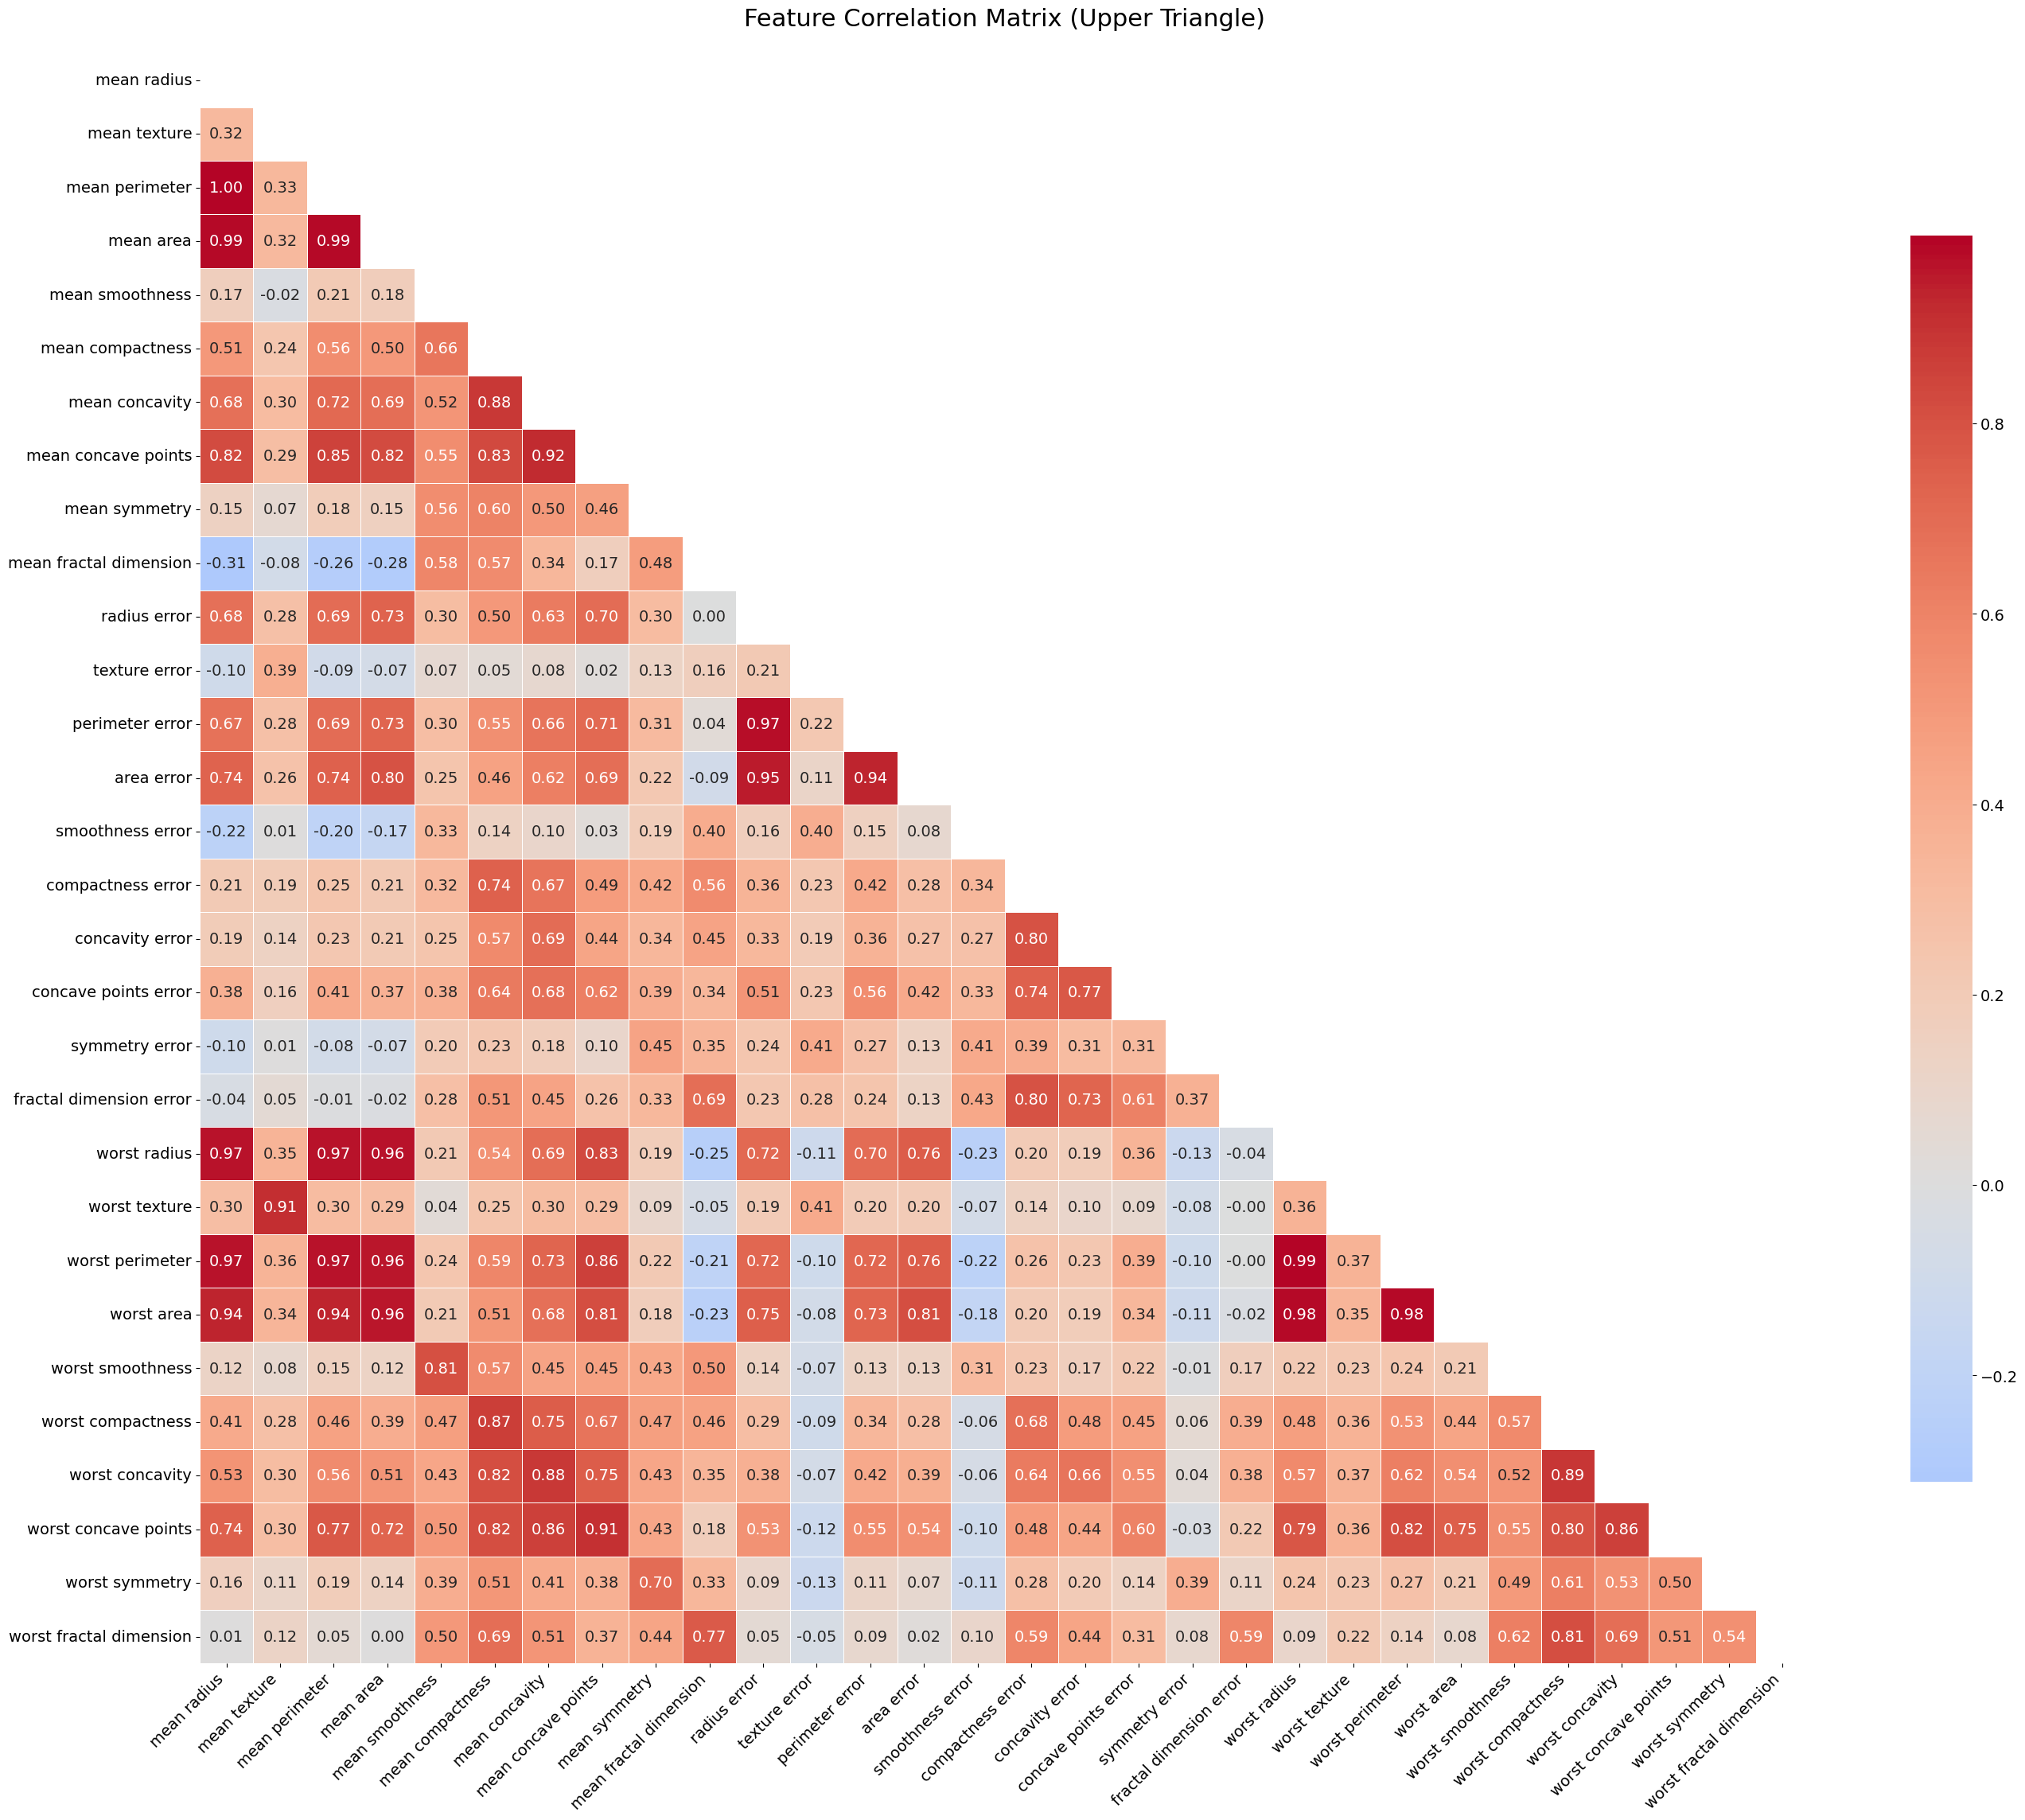

In [139]:
# Calculate correlation matrix
correlation_matrix = X.corr()

# Plot correlation heatmap with annotations (numbers)
plt.figure(figsize=(28, 24))  # Mucho más grande
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

ax = sns.heatmap(
    correlation_matrix, 
    mask=mask, 
    annot=True, 
    fmt='.2f', 
    cmap='coolwarm',
    center=0, 
    square=True, 
    linewidths=0.6,
    cbar_kws={"shrink": 0.7},
    annot_kws={'size': 14}  # Números más grandes dentro del heatmap
)

# Aumentar tamaño de números en la barra de color (leyenda)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)  # Aumenta tamaño de números de la barra de color

plt.xticks(fontsize=14, rotation=45, ha='right') 
plt.yticks(fontsize=14, rotation=0)

plt.title('Feature Correlation Matrix (Upper Triangle)', fontsize=22, pad=25)

plt.tight_layout()
plt.show()


In [140]:
# Find highly correlated features (correlation > 0.9)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            high_corr_pairs.append((
                correlation_matrix.columns[i], 
                correlation_matrix.columns[j], 
                correlation_matrix.iloc[i, j]
            ))

if high_corr_pairs:
    print("Highly correlated feature pairs (|correlation| > 0.9):")
    print("-" * 70)
    for feat1, feat2, corr in high_corr_pairs:
        print(f"{feat1:25s} <->        {feat2:25s} : {corr:.3f}")
    print(f"\nTotal highly correlated pairs: {len(high_corr_pairs)}")
else:
    print("No highly correlated pairs found (threshold: 0.9)")


Highly correlated feature pairs (|correlation| > 0.9):
----------------------------------------------------------------------
mean radius               <->        mean perimeter            : 0.998
mean radius               <->        mean area                 : 0.987
mean radius               <->        worst radius              : 0.970
mean radius               <->        worst perimeter           : 0.965
mean radius               <->        worst area                : 0.941
mean texture              <->        worst texture             : 0.912
mean perimeter            <->        mean area                 : 0.987
mean perimeter            <->        worst radius              : 0.969
mean perimeter            <->        worst perimeter           : 0.970
mean perimeter            <->        worst area                : 0.942
mean area                 <->        worst radius              : 0.963
mean area                 <->        worst perimeter           : 0.959
mean area             

### 6. Feature-Target Relationship Analysis


In [141]:
# Calculate correlation between features and target
X_with_target = X.copy()
X_with_target['target'] = y
feature_target_corr = X_with_target.corr()['target'].drop('target').abs().sort_values(ascending=False)


print("Top 10 features most correlated with target:")
print("-" * 50)
for feat, corr in feature_target_corr.head(10).items():
    print(f"{feat:35s} : {corr:.4f}")


Top 10 features most correlated with target:
--------------------------------------------------
worst concave points                : 0.7936
worst perimeter                     : 0.7829
mean concave points                 : 0.7766
worst radius                        : 0.7765
mean perimeter                      : 0.7426
worst area                          : 0.7338
mean radius                         : 0.7300
mean area                           : 0.7090
mean concavity                      : 0.6964
worst concavity                     : 0.6596


In [142]:
# Top 10 least correlated features with target
least_correlated = feature_target_corr.tail(10)
print("\nTop 10 features least correlated with target:")
print("-" * 50)
for feat, corr in least_correlated.items():
    print(f"{feat:35s} : {corr:.4f}")



Top 10 features least correlated with target:
--------------------------------------------------
mean smoothness                     : 0.3586
mean symmetry                       : 0.3305
worst fractal dimension             : 0.3239
compactness error                   : 0.2930
concavity error                     : 0.2537
fractal dimension error             : 0.0780
smoothness error                    : 0.0670
mean fractal dimension              : 0.0128
texture error                       : 0.0083
symmetry error                      : 0.0065


In [143]:
# list of features correlated less than 0.1 with target
least_correlated_features = feature_target_corr[feature_target_corr < 0.1].index.tolist()
least_correlated_features

['fractal dimension error',
 'smoothness error',
 'mean fractal dimension',
 'texture error',
 'symmetry error']

In [144]:
# for each couple of most correlated features, save the one least correlated with target in a list

least_correlated_in_pair = []

for feat1, feat2, corr in high_corr_pairs:
    if feature_target_corr[feat1] < feature_target_corr[feat2]:
        least_correlated_in_pair.append(feat1)
    else:
        least_correlated_in_pair.append(feat2)


In [145]:
# avoid duplicates
least_correlated_in_pair = list(set(least_correlated_in_pair))
least_correlated_in_pair

['mean texture',
 'worst area',
 'mean concavity',
 'mean perimeter',
 'mean area',
 'perimeter error',
 'area error',
 'worst radius',
 'mean radius',
 'mean concave points']

### 7. Statistical Summary by Class


In [146]:
# Compare statistics between classes for key features
key_features = ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 
                'mean smoothness', 'mean compactness', 'mean concavity', 
                'worst radius', 'worst texture', 'worst area']

print("Statistical Comparison: Malignant vs Benign")
print("=" * 80)

for feat in key_features[:5]:  # Show first 5 for brevity
    print(f"\n{feat}:")
    print(f"  Malignant - Mean: {X[y == 0][feat].mean():.2f}, Std: {X[y == 0][feat].std():.2f}")
    print(f"  Benign    - Mean: {X[y == 1][feat].mean():.2f}, Std: {X[y == 1][feat].std():.2f}")
    print(f"  Difference: {abs(X[y == 0][feat].mean() - X[y == 1][feat].mean()):.2f}")


Statistical Comparison: Malignant vs Benign

mean radius:
  Malignant - Mean: 17.46, Std: 3.20
  Benign    - Mean: 12.15, Std: 1.78
  Difference: 5.32

mean texture:
  Malignant - Mean: 21.60, Std: 3.78
  Benign    - Mean: 17.91, Std: 4.00
  Difference: 3.69

mean perimeter:
  Malignant - Mean: 115.37, Std: 21.85
  Benign    - Mean: 78.08, Std: 11.81
  Difference: 37.29

mean area:
  Malignant - Mean: 978.38, Std: 367.94
  Benign    - Mean: 462.79, Std: 134.29
  Difference: 515.59

mean smoothness:
  Malignant - Mean: 0.10, Std: 0.01
  Benign    - Mean: 0.09, Std: 0.01
  Difference: 0.01


### 8. Feature Scaling Assessment


In [147]:
# Check feature scales
print("Feature Scale Analysis:")
print("=" * 80)
print(f"Min value across all features: {X.min().min():.2f}")
print(f"Max value across all features: {X.max().max():.2f}")
print(f"Range: {X.max().max() - X.min().min():.2f}")

# Check standard deviations
print(f"\nStandard Deviation Analysis:")
print(f"Min std: {X.std().min():.2f}")
print(f"Max std: {X.std().max():.2f}")
print(f"Std ratio (max/min): {X.std().max() / X.std().min():.2f}")

if X.std().max() / X.std().min() > 10:
    print("\n⚠️ Warning: Features have very different scales. Scaling is recommended!")
else:
    print("\n✓ Feature scales are relatively similar")

# Show features with largest and smallest scales
print("\nTop 5 features with largest standard deviations:")
print(X.std().nlargest(5))
print("\nTop 5 features with smallest standard deviations:")
print(X.std().nsmallest(5))


Feature Scale Analysis:
Min value across all features: 0.00
Max value across all features: 4254.00
Range: 4254.00

Standard Deviation Analysis:
Min std: 0.00
Max std: 569.36
Std ratio (max/min): 215170.72

⚠️ Warning: Features have very different scales. Scaling is recommended!

Top 5 features with largest standard deviations:
worst area         569.356993
mean area          351.914129
area error          45.491006
worst perimeter     33.602542
mean perimeter      24.298981
dtype: float64

Top 5 features with smallest standard deviations:
fractal dimension error    0.002646
smoothness error           0.003003
concave points error       0.006170
mean fractal dimension     0.007060
symmetry error             0.008266
dtype: float64


### 9. Outlier Detection (IQR Method)


In [148]:
# Detect outliers using IQR method
def detect_outliers_iqr(df):
    outliers_count = {}
    for col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outliers_count[col] = len(outliers)
    return outliers_count

outliers = detect_outliers_iqr(X)
outliers_df = pd.DataFrame(list(outliers.items()), columns=['Feature', 'Outlier_Count'])
outliers_df['Outlier_Percentage'] = (outliers_df['Outlier_Count'] / len(X) * 100).round(2)
outliers_df = outliers_df.sort_values('Outlier_Count', ascending=False)

print("Outlier Summary (IQR Method):")
print("=" * 60)
print(f"Total features with outliers: {(outliers_df['Outlier_Count'] > 0).sum()}")
print(f"Average outliers per feature: {outliers_df['Outlier_Count'].mean():.1f}")
print(f"\nTop 10 features with most outliers:")
print(outliers_df.head(10).to_string(index=False))


Outlier Summary (IQR Method):
Total features with outliers: 29
Average outliers per feature: 20.3

Top 10 features with most outliers:
                Feature  Outlier_Count  Outlier_Percentage
             area error             65               11.42
           radius error             38                6.68
        perimeter error             38                6.68
             worst area             35                6.15
       smoothness error             30                5.27
fractal dimension error             28                4.92
      compactness error             28                4.92
         symmetry error             27                4.75
              mean area             25                4.39
worst fractal dimension             24                4.22


### 10. EDA Summary and Insights


In [149]:
print("=" * 80)
print("EDA SUMMARY AND INSIGHTS")
print("=" * 80)

print("\n1. DATASET OVERVIEW:")
print(f"   • Total samples: {X.shape[0]}")
print(f"   • Total features: {X.shape[1]}")
print(f"   • Missing values: {X.isnull().sum().sum()} ({'None' if X.isnull().sum().sum() == 0 else 'Present'})")
print(f"   • Duplicate rows: {X.duplicated().sum()}")

print("\n2. TARGET VARIABLE:")
print(f"   • Classes: {data.target_names[0]} (0) and {data.target_names[1]} (1)")
print(f"   • Class distribution: {y.value_counts()[0]} vs {y.value_counts()[1]}")
print(f"   • Class balance: {'Balanced' if abs(y.value_counts()[0] / y.value_counts()[1] - 1) < 0.3 else 'Imbalanced'}")

print("\n3. FEATURE CHARACTERISTICS:")
print(f"   • Feature scale range: {X.min().min():.2f} to {X.max().max():.2f}")
print(f"   • Standard deviation ratio: {X.std().max() / X.std().min():.2f}")
print(f"   • Scaling needed: {'Yes' if X.std().max() / X.std().min() > 10 else 'No'}")

print("\n4. DATA QUALITY:")
print(f"   • Missing values: {'None - Dataset is clean' if X.isnull().sum().sum() == 0 else 'Present - Needs handling'}")
print(f"   • Duplicates: {'None' if X.duplicated().sum() == 0 else 'Present'}")

print("\n5. RECOMMENDATIONS FOR MODELING:")
recommendations = []
if X.std().max() / X.std().min() > 10:
    recommendations.append("✓ Apply feature scaling (StandardScaler or MinMaxScaler)")
if len(high_corr_pairs) > 0:
    recommendations.append(f"✓ Consider feature selection (remove highly correlated features: {len(high_corr_pairs)} pairs)")
if abs(y.value_counts()[0] / y.value_counts()[1] - 1) > 0.3:
    recommendations.append("✓ Handle class imbalance (use class_weight='balanced' or SMOTE)")
else:
    recommendations.append("✓ Classes are balanced - no special handling needed")
recommendations.append("✓ Dataset is clean - no missing value handling needed")
recommendations.append("✓ Use cross-validation for robust model evaluation")

for rec in recommendations:
    print(f"   {rec}")

print("\n" + "=" * 80)


EDA SUMMARY AND INSIGHTS

1. DATASET OVERVIEW:
   • Total samples: 569
   • Total features: 30
   • Missing values: 0 (None)
   • Duplicate rows: 0

2. TARGET VARIABLE:
   • Classes: malignant (0) and benign (1)
   • Class distribution: 212 vs 357
   • Class balance: Imbalanced

3. FEATURE CHARACTERISTICS:
   • Feature scale range: 0.00 to 4254.00
   • Standard deviation ratio: 215170.72
   • Scaling needed: Yes

4. DATA QUALITY:
   • Missing values: None - Dataset is clean
   • Duplicates: None

5. RECOMMENDATIONS FOR MODELING:
   ✓ Apply feature scaling (StandardScaler or MinMaxScaler)
   ✓ Consider feature selection (remove highly correlated features: 21 pairs)
   ✓ Handle class imbalance (use class_weight='balanced' or SMOTE)
   ✓ Dataset is clean - no missing value handling needed
   ✓ Use cross-validation for robust model evaluation



## Data preparation

In [150]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [151]:
print(f'Trainiing set: {X_train.shape[0]} samples')
print(f'Test set {X_test.shape[0]} samples')
print(f"Training - Class distribution:\n{y_train.value_counts()}")
print(f"Test - Class distribution:\n{y_test.value_counts()}")

Trainiing set: 455 samples
Test set 114 samples
Training - Class distribution:
1    285
0    170
Name: count, dtype: int64
Test - Class distribution:
1    72
0    42
Name: count, dtype: int64


## Feature selection

In [152]:
# drop features least correlated with target
X_train_reduced = X_train.copy()
X_train_reduced = X_train_reduced.drop(least_correlated_features, axis=1)
X_train_reduced.shape[1]

25

In [153]:
# for each pair of most correlated features, drop the one least correlated with the target

X_train_reduced = X_train_reduced.drop(least_correlated_in_pair, axis=1)
X_train_reduced.shape[1]

15

In [154]:
selected_features = X_train_reduced.columns.tolist()

In [155]:
selected_features

['mean smoothness',
 'mean compactness',
 'mean symmetry',
 'radius error',
 'compactness error',
 'concavity error',
 'concave points error',
 'worst texture',
 'worst perimeter',
 'worst smoothness',
 'worst compactness',
 'worst concavity',
 'worst concave points',
 'worst symmetry',
 'worst fractal dimension']

Apply same process for y_train

In [156]:
X_test_reduced = X_test.copy()
X_test_reduced = X_test_reduced.drop(least_correlated_features, axis=1)
X_test_reduced.shape[1]

25

In [157]:
X_test_reduced = X_test_reduced.drop(least_correlated_in_pair, axis=1)
X_test_reduced.shape[1]

15

## Model definitions

In [158]:
# Define cross-validation strategy (StratifiedkFold for imbalanced data)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Models to compare

models = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(random_state=42, max_iter=1000))
    ]),

    'Random Forest': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
    ]),

    'Gradient Boosting': Pipeline([
        ('scaler', StandardScaler()),
         ('classifier', GradientBoostingClassifier(random_state=42))
    ]),

    'SVM': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', SVC(random_state=42, probability=True))
    ]),

    'K-Nearest Neighbors': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', KNeighborsClassifier(n_jobs=-1))
    ]),

    'XGBoost': Pipeline([
        ('scaler', StandardScaler()),
        ('model', XGBClassifier(random_state=42))
    ])
}

## Model comparison with cross-validation

In [159]:
cv_results = {}
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

for name, model in models.items():

    # perform cross-validation with multiple metrics:
    cv_scores = cross_validate(model, X_train_reduced, y_train, cv=cv, scoring=scoring_metrics, return_train_score=True, n_jobs=-1)

    cv_results[name] = {
        'test_accuracy': cv_scores['test_accuracy'],
        'test_precision': cv_scores['test_precision'],
        'test_recall': cv_scores['test_recall'],
        'test_f1': cv_scores['test_f1'],
        'test_roc_auc': cv_scores['test_roc_auc'],
        'train_accuracy': cv_scores['train_accuracy']
    }


# Create comparison DataFrame
comparison_df = pd.DataFrame({
    name: {
        'Accuracy': f"{results['test_accuracy'].mean():.4f} ± {results['test_accuracy'].std():.4f}",
        'Precision': f"{results['test_precision'].mean():.4f} ± {results['test_precision'].std():.4f}",
        'Recall': f"{results['test_recall'].mean():.4f} ± {results['test_recall'].std():.4f}",
        'F1-Score': f"{results['test_f1'].mean():.4f} ± {results['test_f1'].std():.4f}",
        'ROC-AUC': f"{results['test_roc_auc'].mean():.4f} ± {results['test_roc_auc'].std():.4f}"
    }
    for name, results in cv_results.items()
}).T

print("\n" + "=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)
print(comparison_df)

# Select best model based on F1-score (good balance for imbalanced data)
best_model_name = max(cv_results.keys(), 
                     key=lambda x: cv_results[x]['test_f1'].mean())
print(f"\n🏆 Best model (based on F1-score): {best_model_name}")



MODEL COMPARISON SUMMARY
                            Accuracy        Precision           Recall  \
Logistic Regression  0.9736 ± 0.0132  0.9694 ± 0.0162  0.9895 ± 0.0140   
Random Forest        0.9385 ± 0.0192  0.9478 ± 0.0103  0.9544 ± 0.0285   
Gradient Boosting    0.9626 ± 0.0204  0.9659 ± 0.0239  0.9754 ± 0.0238   
SVM                  0.9626 ± 0.0132  0.9625 ± 0.0191  0.9789 ± 0.0070   
K-Nearest Neighbors  0.9407 ± 0.0112  0.9422 ± 0.0161  0.9649 ± 0.0157   
XGBoost              0.9692 ± 0.0176  0.9728 ± 0.0226  0.9789 ± 0.0205   

                            F1-Score          ROC-AUC  
Logistic Regression  0.9792 ± 0.0104  0.9961 ± 0.0038  
Random Forest        0.9509 ± 0.0159  0.9877 ± 0.0074  
Gradient Boosting    0.9703 ± 0.0161  0.9909 ± 0.0043  
SVM                  0.9705 ± 0.0102  0.9950 ± 0.0018  
K-Nearest Neighbors  0.9532 ± 0.0087  0.9774 ± 0.0069  
XGBoost              0.9756 ± 0.0138  0.9941 ± 0.0043  

🏆 Best model (based on F1-score): Logistic Regression


## Hyperparameter tuning for best model

In [160]:
# define parameter grids for logistic regression

# Define parameter grids for different models
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'saga'],
        'classifier__class_weight': [None, 'balanced']
    },
    
    'Random Forest': {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [10, 20, 30, None],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__class_weight': [None, 'balanced']
    },
    
    'Gradient Boosting': {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7],
        'classifier__min_samples_split': [2, 5]
    },
    
    'SVM': {
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__gamma': ['scale', 'auto', 0.001, 0.01],
        'classifier__kernel': ['rbf', 'linear']
    },
    
    'K-Nearest Neighbors': {
        'classifier__n_neighbors': [3, 5, 7, 9, 11],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['euclidean', 'manhattan']
    }
}

# perform GridSearchCV

best_model_pipeline = models[best_model_name]
param_grid = param_grids[best_model_name]

grid_search = GridSearchCV(best_model_pipeline, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train_reduced, y_train )

print(f"Best parameters:")
for param, value in grid_search.best_params_.items():
    print(f" {param}: {value}")
print(f"\nBest cross-validation F1-score: {grid_search.best_score_:.4f}")

# Get the best model
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters:
 classifier__C: 1
 classifier__class_weight: balanced
 classifier__penalty: l1
 classifier__solver: liblinear

Best cross-validation F1-score: 0.9823


## Final model evaluation on test set

In [161]:
best_model

,steps,"[('scaler', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l1'
,dual,False
,tol,0.0001
,C,1


In [162]:
# make predictions
y_pred = best_model.predict(X_test_reduced)
y_pred_proba = best_model.predict_proba(X_test_reduced)[:,1]

In [163]:
# calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

In [164]:
print(f"\nTest Set Performance:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")
print(f"  ROC-AUC:   {roc_auc:.4f}")

# Confusion Matrix
print("\n" + "=" * 80)
print("CONFUSION MATRIX")
print("=" * 80)
cm = confusion_matrix(y_test, y_pred)
print(f"\n{cm}")
print(f"\nTrue Negatives (TN): {cm[0,0]}")
print(f"False Positives (FP): {cm[0,1]}")
print(f"False Negatives (FN): {cm[1,0]}")
print(f"True Positives (TP): {cm[1,1]}")



Test Set Performance:
  Accuracy:  0.9561
  Precision: 0.9855
  Recall:    0.9444
  F1-Score:  0.9645
  ROC-AUC:   0.9970

CONFUSION MATRIX

[[41  1]
 [ 4 68]]

True Negatives (TN): 41
False Positives (FP): 1
False Negatives (FN): 4
True Positives (TP): 68


In [165]:
# true malignant: 41
# false benign: 1
# false malignant: 4
# true benign: 68

## Visualizations

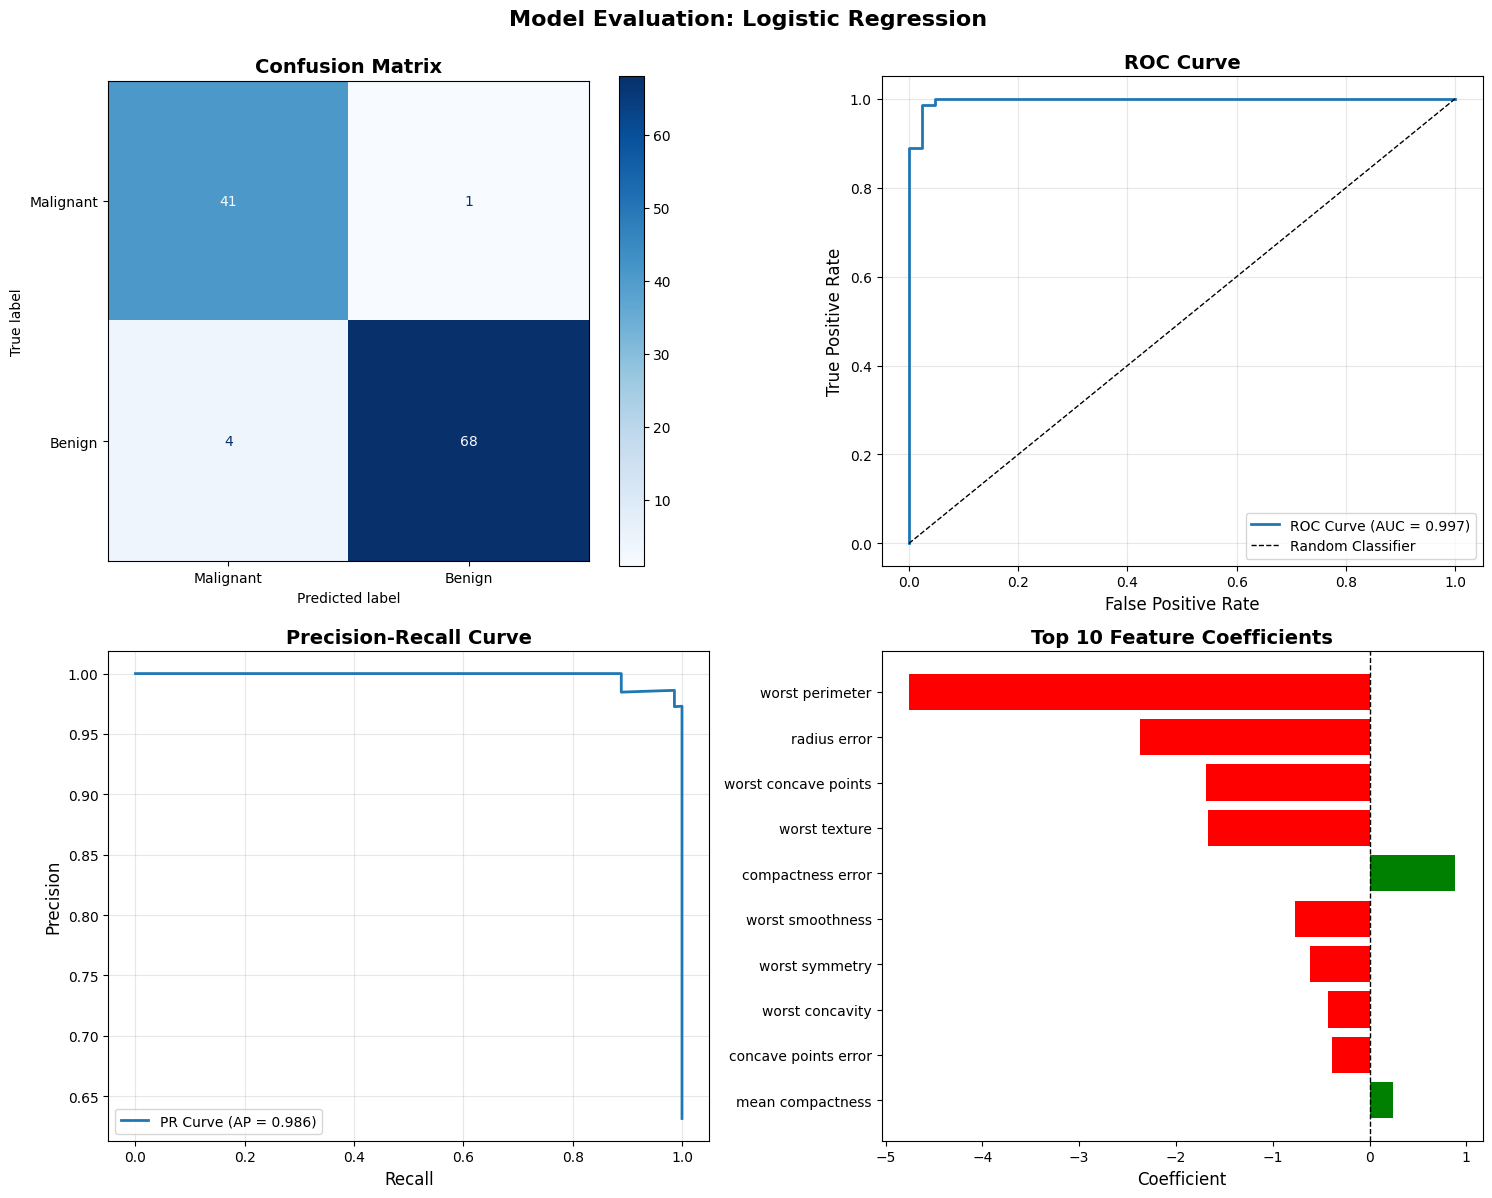

In [166]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Confusion Matrix Heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['Malignant', 'Benign'])
disp.plot(ax=axes[0, 0], cmap='Blues', values_format='d')
axes[0, 0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[0, 1].plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
axes[0, 1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[0, 1].set_xlabel('False Positive Rate', fontsize=12)
axes[0, 1].set_ylabel('True Positive Rate', fontsize=12)
axes[0, 1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0, 1].legend(loc='lower right')
axes[0, 1].grid(alpha=0.3)

# 3. Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
axes[1, 0].plot(recall_curve, precision_curve, linewidth=2, 
                label=f'PR Curve (AP = {precision:.3f})')
axes[1, 0].set_xlabel('Recall', fontsize=12)
axes[1, 0].set_ylabel('Precision', fontsize=12)
axes[1, 0].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[1, 0].legend(loc='lower left')
axes[1, 0].grid(alpha=0.3)

# 4. Feature Importance (if available)
if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    importances = best_model.named_steps['classifier'].feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': selected_features,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    top_features = feature_importance_df.head(10)
    axes[1, 1].barh(range(len(top_features)), top_features['importance'])
    axes[1, 1].set_yticks(range(len(top_features)))
    axes[1, 1].set_yticklabels(top_features['feature'])
    axes[1, 1].set_xlabel('Importance', fontsize=12)
    axes[1, 1].set_title('Top 10 Feature Importances', fontsize=14, fontweight='bold')
    axes[1, 1].invert_yaxis()
elif hasattr(best_model.named_steps['classifier'], 'coef_'):
    # For linear models, show coefficients
    coef = best_model.named_steps['classifier'].coef_[0]
    coef_df = pd.DataFrame({
        'feature': selected_features,
        'coefficient': coef
    }).sort_values('coefficient', key=abs, ascending=False)
    
    top_features = coef_df.head(10)
    colors = ['red' if x < 0 else 'green' for x in top_features['coefficient']]
    axes[1, 1].barh(range(len(top_features)), top_features['coefficient'], color=colors)
    axes[1, 1].set_yticks(range(len(top_features)))
    axes[1, 1].set_yticklabels(top_features['feature'])
    axes[1, 1].set_xlabel('Coefficient', fontsize=12)
    axes[1, 1].set_title('Top 10 Feature Coefficients', fontsize=14, fontweight='bold')
    axes[1, 1].axvline(x=0, color='black', linestyle='--', linewidth=1)
    axes[1, 1].invert_yaxis()
else:
    axes[1, 1].text(0.5, 0.5, 'Feature importance\nnot available\nfor this model', 
                    ha='center', va='center', fontsize=12)
    axes[1, 1].set_title('Feature Importance', fontsize=14, fontweight='bold')

plt.suptitle(f'Model Evaluation: {best_model_name}', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()